# Logistic regression on Criteo dataset without Spark MLlib

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!curl -O https://dlcdn.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop3.2.tgz
!tar xf spark-3.2.3-bin-hadoop3.2.tgz
!pip install -q findspark

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  287M  100  287M    0     0   284M      0  0:00:01  0:00:01 --:--:--  284M


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()
ss = spark

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import types as st
from pyspark.sql import functions as sf
from pyspark.sql import Row, DataFrame
from pyspark import RDD
from pyspark import StorageLevel

In [5]:
%matplotlib inline

In [6]:
import math
import urllib
import matplotlib.pyplot as plot
from typing import Tuple, Dict

In [7]:
integer_features = [f"int_feat_{i}" for i in range(1, 14)]
categorical_features = [f"cat_feat_{i}" for i in range(1, 27)]

fields = []

fields.append(
    st.StructField("label", st.IntegerType(), nullable=False)
)

for int_feat in integer_features:
    fields.append(st.StructField(int_feat, st.IntegerType(), nullable=True))
    
for cat_feat in categorical_features:
    fields.append(st.StructField(cat_feat, st.StringType(), nullable=True))

schema = st.StructType(fields)

In [8]:
from urllib import request
toy_dataset_url = 'https://www.dropbox.com/s/hn2pt29gbne9c99/criteo_toy_dataset-part2.txt?dl=1'
request.urlretrieve(toy_dataset_url, "train.txt")

('train.txt', <http.client.HTTPMessage at 0x7f4954a092e0>)

In [9]:
full_df = ss.read.csv(
    path="train.txt",
    sep="\t",
    header=None,
    schema=schema
)

In [11]:
full_df.agg(
    sf.count('*').alias('num_examples'),
    sf.sum('label').alias('num_positives'),
    sf.sum(sf.expr('label == 0').cast('int')).alias('num_negatives'),
    sf.mean('label').alias('avg_label')
).toPandas()

,num_examples,num_positives,num_negatives,avg_label
0,388288,98598,289690,0.25393


## Convert to vector with one hot encoding

### Select subset of features based on number of modalities

In [12]:
threshold = 100
num_modalities = {} 
for cat_feat in categorical_features:
    num_modalities[cat_feat] = full_df \
        .filter(sf.col(cat_feat).isNotNull()) \
        .groupby(cat_feat) \
        .count() \
        .filter(sf.col('count') > sf.lit(threshold)) \
        .count()
num_modalities

{'cat_feat_1': 61,
 'cat_feat_2': 257,
 'cat_feat_3': 294,
 'cat_feat_4': 383,
 'cat_feat_5': 29,
 'cat_feat_6': 6,
 'cat_feat_7': 736,
 'cat_feat_8': 41,
 'cat_feat_9': 2,
 'cat_feat_10': 534,
 'cat_feat_11': 735,
 'cat_feat_12': 301,
 'cat_feat_13': 699,
 'cat_feat_14': 23,
 'cat_feat_15': 662,
 'cat_feat_16': 333,
 'cat_feat_17': 9,
 'cat_feat_18': 495,
 'cat_feat_19': 167,
 'cat_feat_20': 3,
 'cat_feat_21': 310,
 'cat_feat_22': 6,
 'cat_feat_23': 12,
 'cat_feat_24': 362,
 'cat_feat_25': 31,
 'cat_feat_26': 238}

In [13]:
low_card_cat_feat = [cat_feat for cat_feat, num_modalities in num_modalities.items() if num_modalities < 50]
low_card_cat_feat

['cat_feat_5',
 'cat_feat_6',
 'cat_feat_8',
 'cat_feat_9',
 'cat_feat_14',
 'cat_feat_17',
 'cat_feat_20',
 'cat_feat_22',
 'cat_feat_23',
 'cat_feat_25']

### Build map for one hot encoding

In [14]:
modalities = {}
for cat_feat in low_card_cat_feat:
    rows = full_df\
        .filter(sf.col(cat_feat).isNotNull())\
        .groupby(cat_feat)\
        .count()\
        .filter(sf.col('count') > sf.lit(threshold))\
        .select(cat_feat)\
        .collect()
    modalities[cat_feat] = [row[cat_feat] for row in rows]

In [15]:
one_hot_encoder = {cat_feat:{} for cat_feat in low_card_cat_feat}
index = 0
for cat_feat in low_card_cat_feat:
    for value in modalities[cat_feat]:
        one_hot_encoder[cat_feat][value] = index
        index += 1
    one_hot_encoder[cat_feat][None] = index
    index += 1
dimension = index + 1 # dimension is nb_of_modalities + 1 for the intercept
dimension

173

### Sparse methods

In [16]:
import functools
def dot_product(x: Dict[int,float], y: Dict[int,float]):
  return functools.reduce(lambda a,b : a+b, [x[k]*y[k] for k in x.keys() & y.keys()])

def product(x: Dict[int,float], coeff: float):
  return {k:coeff*x[k] for k in x.keys()}

epsilon = 1e-12
def sum(a: Dict[int,float], b : Dict[int, float], coeff=1.0) -> Dict[int, float]:
  return {k:(a.get(k,0) + coeff * b.get(k,0)) for k in (a.keys() | b.keys()) if abs(a.get(k,0) + coeff * b.get(k,0)) > epsilon}

def minus(a: Dict[int,float], b: Dict[int,float]):
  return {k:a.get(k,0)*b.get(k,0) for k in a.keys()|b.keys()}

def np_sum(v):
  return functools.reduce(lambda a,b : a+b, v)

### Convert to vector

In [17]:
def row_to_vector(
    row: Row, dimension: int, encoder: Dict[str, Dict[str, int]]
) -> Tuple[Dict[int,float], int]:
    x = {}
    x[dimension-1] = 1 # for intercept
    y = row['label']
    for feat in encoder.keys():
        value = row[feat]
        index = encoder[feat].get(value, None)
        if index != None:
            x[index] = 1
    return x, y

In [18]:
def convert_to_vectors(
    df: DataFrame, dimension: int, encoder: Dict[str, Dict[str, int]]
) -> RDD:
    features = encoder.keys()
    return df\
        .select('label', *features).rdd\
        .map(lambda row: row_to_vector(row, dimension, encoder))

In [19]:
convert_to_vectors(full_df, dimension, one_hot_encoder).first()

({172: 1,
  12: 1,
  35: 1,
  71: 1,
  79: 1,
  100: 1,
  110: 1,
  116: 1,
  126: 1,
  132: 1,
  148: 1},
 0)

## Compute loss

In [20]:
def sigmoid(x: float) -> float:
    return 1 / (1 + math.exp(-x))

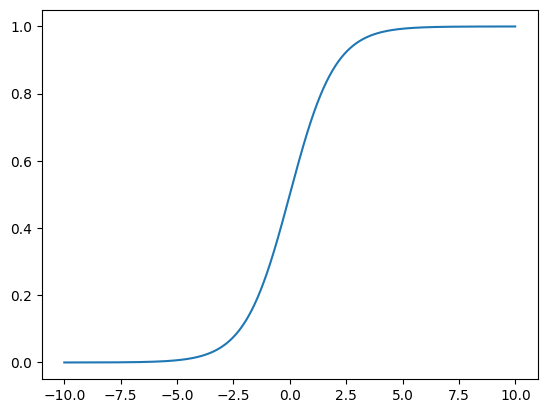

In [21]:
X = [-10+0.01*i for i in range(2000)]
plot.plot(X, [sigmoid(x) for x in X])

In [22]:
def point_predict(x: Dict[int,float], model: Dict[int,float]) -> float:
  return sigmoid(dot_product(x, model))

In [23]:
def point_loss(prediction: float, y: int) -> float:
  return - y * math.log(prediction) - (1-y) * math.log(1-prediction)

In [24]:
def compute_loss(vec_label_rdd: RDD, model: Dict[int,float], num_examples: int) -> float:
    sum_loss = (vec_label_rdd
        .map(lambda vec_lab: point_loss(point_predict(vec_lab[0], model), vec_lab[1]))
        .reduce(lambda u, v: u+v)
               )
    return sum_loss / num_examples

## Compute gradient of the loss

In [ ]:
def point_gradient(x: Dict[int,float], y: int, model: Dict[int,float]) -> float:
    dp = dot_product(x, model)
    p = sigmoid(dp)
    return product(x, p-y)

In [ ]:
def compute_gradient(vec_label_rdd: RDD, model: Dict[int,float], num_examples: int) -> Dict[int,float]:
    sum_gradient = (vec_label_rdd
        .map(lambda vec_lab: point_gradient(vec_lab[0], vec_lab[1], model))
        .reduce(lambda u, v: sum(u,v))
                   )
    return product(sum_gradient, 1.0/num_examples)

## Check gradient with finite differences

In [ ]:
def point_gradient_fd(x, y, model, h=0.001):
    dimension = len(x)
    gradient = {}
    for i in range(0, dimension):
        delta = {}
        delta[i] = h
        
        loss_up = point_loss(point_predict(x, sum(model, delta)), y)
        loss_down = point_loss(point_predict(x, sum(model, delta)), y)
        
        this_loss = (loss_up - loss_down) / (2*h)
        if abs(this_loss) > epsilon:
          gradient[i] = this_loss
    return gradient

In [ ]:
from random import uniform
def np_random_uniform(start, end, size):
  return {i:uniform(start,end) for i in range(size)}

model = np_random_uniform(-1.0, 1.0, dimension)
x = np_random_uniform(-1.0, 1.0, dimension)
y = 0

In [ ]:
def np_abs(v):
  return {i:abs(v[i]) for i in range(len(v))}
np_sum(np_abs(minus(point_gradient_fd(x, y, model), point_gradient(x, y, model))))

## Distributed Gradient Descent

In [ ]:
def logit(x: float) -> float:
    return math.log( x / (1-x) )

In [ ]:
np_sum(np_abs([x - logit(sigmoid(x)) for x in X]))

In [ ]:
def smart_init(dimension: int, avg_label: float) -> Dict[int,float]:
    init_model = {}
    init_model[dimension-1] = logit(avg_label)
    return init_model

In [ ]:
def train(
    training_set: DataFrame,
    dimension: int,
    encoder: Dict[str, Dict[str, int]],
    nb_iter: int,
    lr: float
) -> Tuple[Dict[int,float], float]:
    num_examples, avg_label = training_set.agg(
        sf.count('*').alias('num_examples'),
        sf.mean('label').alias('avg_label')
    ).collect()[0]
    print(f'Num examples: {num_examples}, average label: {avg_label}')
    model = smart_init(dimension, avg_label)
    vector_label_rdd = convert_to_vectors(training_set, dimension, encoder).persist()
    for it in range(0, nb_iter):
        loss = compute_loss(vector_label_rdd, model, num_examples)
        print(f'Loss at step {it}: {loss}')
        gradient = compute_gradient(vector_label_rdd, model, num_examples)
        model = sum(model, gradient, -lr)
    final_loss = compute_loss(vector_label_rdd, model, num_examples)
    print(f'Loss at step {nb_iter}: {final_loss}')
    return model, final_loss

In [ ]:
model, loss = train(full_df, dimension, one_hot_encoder, 10, 1)

In [ ]:
print(f'intercept -> {model[dimension-1]}')
print(f'nb coefficients -> {len(model.keys())}')
for dim in one_hot_encoder.keys():
    for mod, index in one_hot_encoder[dim].items():
      print(f'{dim}={mod} -> {model.get(index,0)}')

In [ ]:
ss.stop()

### More questions

* use sparse vectors
* add feature hashing
* merge loss and gradient computation in one function
* use lbfgs from scipy